In [ ]:

%matplotlib inline
import numpy as np
import matplotlib.pylab as plt


from IPython.display import Markdown
plt.style.use('bmh')
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'legend.fontsize': 20})


On fait la minimitation  pas avec les données directament, mais avec les donnés déjà dans l'histogram, cad, avec le *binned data*. On va comparer le contenue des bins avec la prediction de notre modele.

In [ ]:
def gauss(x, mu, sigma, norm):
    return N / np.sqrt(2*np.pi)/sigma * np.exp(-0.5*(x - mu)**2/sigma**2)

### Ajustement d'une gaussiane

On va faire l'ajustement des parametres d'une gaussiane. Pour ça on va génerer une gaussiane avec le méthode de Hit & Miss avec les parametre suivant:

In [ ]:
from argparse import Namespace

truth = Namespace(mu = 200, sigma = 50, norm = 1)

In [ ]:
xmin = truth.mu - 5 * truth.sigma
xmax = truth.mu + 5 * truth.sigma
mc_events = 1000000

Maintenant on va faire le méthode de Hit & Miss

In [82]:
rnd1 = np.random.rand(mc_events)
rnd2 = np.random.rand(mc_events)
y = truth.norm*rnd1
x = xmin + (xmax - xmin)*rnd2
yprime = gauss(x, **vars(truth))

mask = (y < yprime)

data = x[mask]

n_total = len(data)

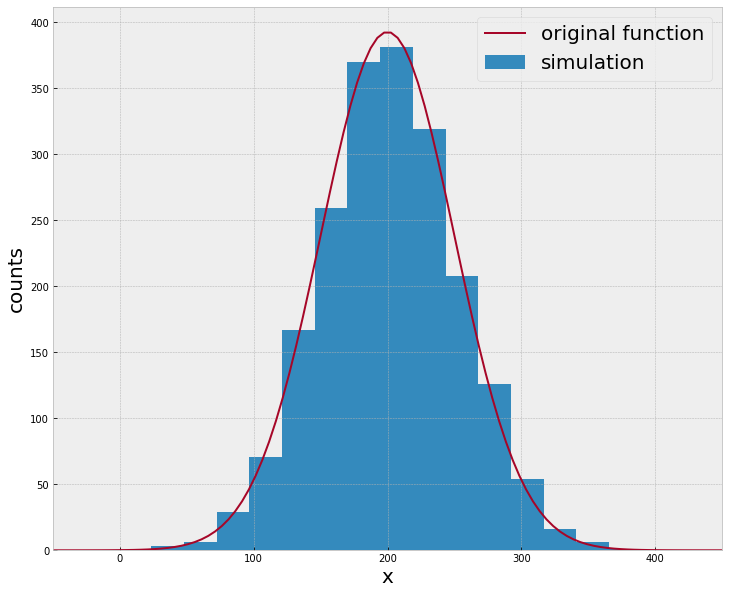

In [89]:
fig, ax = plt.subplots(figsize=(12,10))

hist, binsedges, patches = ax.hist(data, bins = 15, density=False, label="simulation")
ax.set_xlabel("x")
ax.set_ylabel("counts")
ax.set_xlim(xmin, xmax)

#Let's calculate the bincenters
binscenters = binsedges[:-1] + np.diff(binsedges)/2.
binwidths = np.diff(binsedges)


x_grid = np.linspace(xmin, xmax, 100) 
ax.plot(x_grid, n_total*binwidths[0]*gauss(x_grid, **vars(truth)), lw=2, label="original function")
ax.legend()
plt.show()


### Minimitation avec le méthode des moindres carrés

In [90]:
(hist == 0)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [104]:
mumin = 195.
mumax = 205.

mm = np.linspace(mumin, mumax, 50)

Q = []
for m in mm:
    Q.append(
        np.sum((hist - n_total*binwidths[0]*gauss(binscenters, m, truth.sigma, truth.norm))**2/hist)) 
        
mubest = mm[np.where(Q == np.min(Q))]

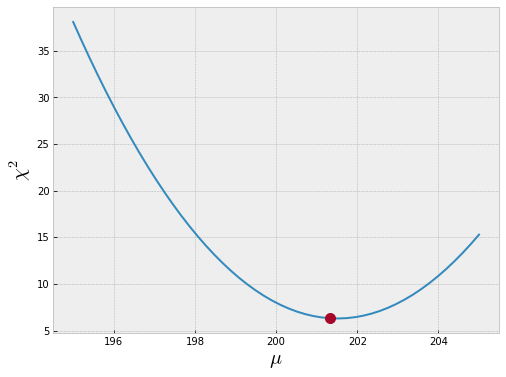

In [112]:
fig3, ax3 = plt.subplots(figsize=(8,6))

ax3.plot(mm, Q)
ax3.set_xlabel(r"$\mu$ ")
ax3.set_ylabel("$\chi^2$")
ax3.plot(mubest, np.min(Q),'o', ms=10)
plt.show()

### Minimization using the Likelihood method

Here we are going to use the raw-data ie, we are not going to use the histogram but directly the array data

In [182]:
mumin = 195.
mumax = 205.
L = []

       
mm = np.linspace(mumin, mumax, 200)

for m in mm:
    P = gauss(data, m, sigma, 1.)
    L.append(-np.sum(np.log(P)))
    

In [183]:
mm[(L == np.min(L))]

array([200.02512563])

In [184]:
    
    
mubest = mm[(L == np.min(L))].flatten()

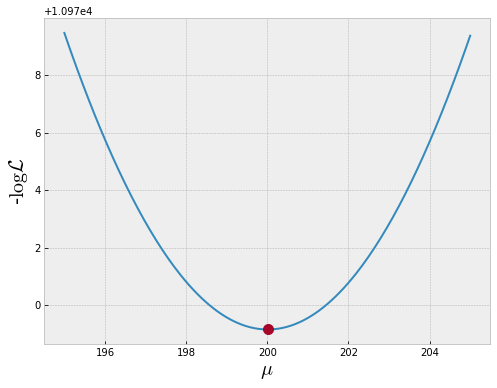

In [185]:
fig1, ax1 = plt.subplots(figsize=(8,6))
#plt.grid()
ax1.plot(mm, L)
ax1.set_xlabel(r"$\mu$ ")
ax1.set_ylabel("-$\log \mathcal{L}$")
ax1.plot(mubest, np.min(L),'o', ms=10)

plt.show()



In [ ]:
fig2, ax2 = plt.subplots(figsize=(12,10))
ax2.errorbar(bincenters, hist, np.sqrt(hist), label="Data")
x = np.arange(0, xmax, 0.1)


ax2.plot(x, gauss(x, mubest, truth.sigma, truth.norm), lw =2 , label=r"Best fitted $\mu$ = {:.2f}".format(mubest[0]))

ax2.set_xlabel("x", fontsize=15)
ax2.set_ylabel("density", fontsize=15)
ax2.set_xlim(xmin, xmax)
ax2.legend(loc="upper right")
plt.show()

On peut aussi estimer l'erreur associé au valeur ajusté. Il faut simplement trouver quand le valuer minimal de $-\log\mathcal{L}$ change pour 1, 2, 3 unités... ça donnerá l'erreur à 1$\sigma$, 2$\sigma$ou 3$\sigma$.

In [200]:
# Two ways to calculate where logL is logL_min + 0.5
#Using np.isclose:    
np.where(np.isclose(L, np.min(L) + 0.5, rtol=2e-6))

(array([ 78, 122]),)

In [202]:
#Usign sign, and diff
mask = np.argwhere(np.diff(np.sign(L - (np.min(L) + 0.5)) )).flatten()

In [203]:
L = np.array(L)
L[mask]

array([10969.68810423, 10969.62122157])

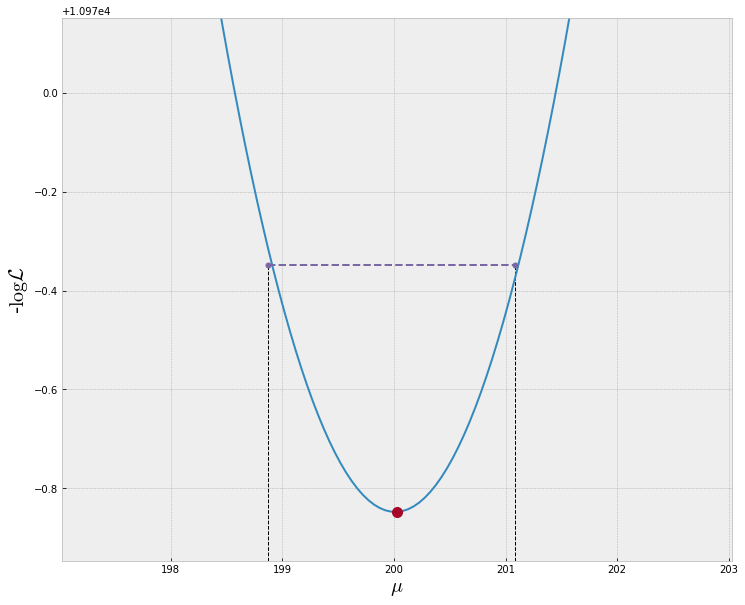

In [205]:
fig1, ax1 = plt.subplots(figsize=(12,10))

ax1.plot(mm, L)
ax1.set_xlabel(r"$\mu$ ")
ax1.set_ylabel("-$\log \mathcal{L}$")
ax1.plot(mubest, np.min(L),'o', ms=10)

ax1.plot(mm[mask], 2*[np.min(L) + 0.5], 'o', ms=5, linestyle='--')

ax1.vlines(x = mm[mask][0], ymin = np.min(L) - 0.1, ymax = np.min(L) + 0.5 ,lw = 1, linestyle="--")
ax1.vlines(x = mm[mask][1], ymin = np.min(L) - 0.1, ymax = np.min(L) + 0.5, lw = 1, linestyle="--")

ax1.set_ylim(np.min(L) - 0.1, np.min(L) + 1)
ax1.set_xlim(mubest - 3,mubest + 3)
plt.show()


L'erreur sour le valeur $\mu$ est un'estimation de combient le valuer estimé de $\mu$ peut changer si on repete plusier fois l'experience. Avec des méthodes de MonteCarlo est possible de repeter l'experience en generant plusier echantions des donnés. On va génerere 1000 fois une gaussiane, et ajuster 1000 fois cettes gaussiens!

In [206]:
mumin = 100.
mumax = 300.

mm = np.arange(mumin, mumax, 0.5)

mubests = []
#here we are going to use the Hit&Miss method 1000 times, and for each time we generate a sample of mc_events
for i in range(0, 1000):
    rnd1 = np.random.rand(mc_events)
    rnd2 = np.random.rand(mc_events)
    y = truth.norm*rnd1
    x = xmin + (xmax - xmin)*rnd2
    yprime = gauss(x, **vars(truth))

    data = x[np.where(y < yprime)]
    L = []
    for m in mm:
        P = gauss(data, m, truth.sigma, truth.norm)
        L.append(-np.sum(np.log(P)))
        
    #For each fit of these 1000 gaussians, we take the best estimated mu value and put in a array    
    mubests.append(mm[np.where(L == np.min(L))])

mubests = np.array(mubests).flatten()

Maintenant on a 1000 estimations des $\mu$ pour 1000 gaussienes statisticament identiques. On peut voir que la distribution des $\mu$ a un ecart type que sera celui estime pour le méthode de vraissemblance.

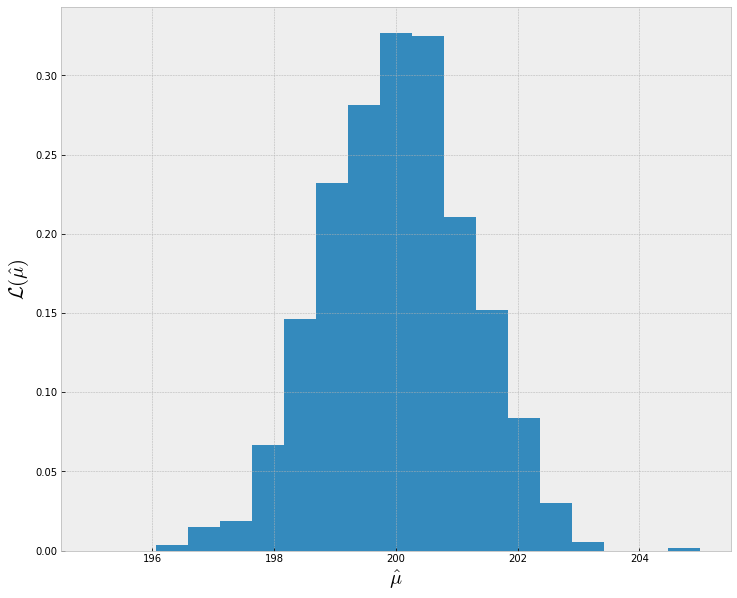

1000


In [212]:
fig1, ax1 = plt.subplots(figsize=(12,10))
ax1.hist(mubests, bins = np.linspace(195, 205, 20), density=True)
ax1.set_ylabel("$\mathcal{L(\hat{\mu})}$")
ax1.set_xlabel("$\hat{\mu}$")
plt.show()
print (len(mubests))

### Ajustement des plusiers parametres

Pour l'instance on avait simplement ajusté un seul parametre $\mu$ en fixant l'écart type $\sigma$. Il es possible de faire l'ajustement pour le deux à la même fois. On doit simplement faire une scan pour le deux parametres.

In [213]:
# Make a grid scan of chi2 values:
mumin = 190.
mumax = 210.

sigma_min = 44.
sigma_max = 55.
mu_grid    = np.arange(mumin, mumax, 0.1)
sigma_grid = np.arange(sigma_min, sigma_max, 0.1)

L = []
for m in mu_grid:
    L_m = []
    for s in sigma_grid:
        P = gauss(data, m, s, truth.norm)
        L_m.append(-np.sum(np.log(P)))
       
    L.append(L_m)
    
# a list of lists => a 2d array
L = np.array(L)

In [214]:
i_best = np.where(L == L.min())

print (i_best)

mu_best = mu_grid[i_best[0]]
sigma_best = sigma_grid[i_best[1]]

print (mu_best, sigma_best)

(array([101]), array([68]))
[200.1] [50.8]


Text(0, 0.5, '$\\mu$')

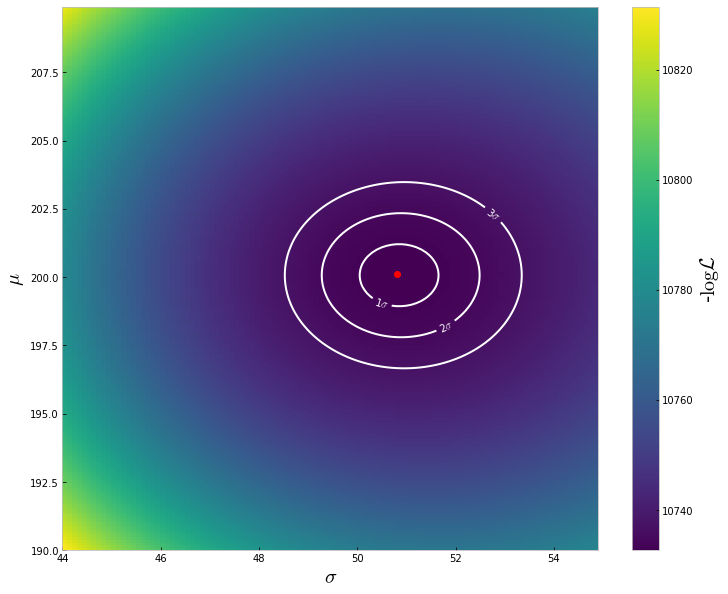

In [220]:
fig1, ax1 = plt.subplots(figsize=(12,10))


mesh = ax1.pcolormesh(sigma_grid, mu_grid, L)

cs = ax1.contour(sigma_grid, mu_grid, L, [L.min() + 0.5, L.min() + 4./2., L.min() + 9./2.],colors='white')

fmt = {}
strs = ['1$\sigma$', '2$\sigma$', '3$\sigma$']
for l, s in zip(cs.levels, strs):
    fmt[l] = s

plt.clabel(cs, cs.levels, inline=1, fmt=fmt, fontsize=20)

plt.plot(sigma_best, mu_best, marker='o',color='r')
cbar = plt.colorbar(mesh)
cbar.ax.set_ylabel('-$\log \mathcal{L}$')

plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')
 

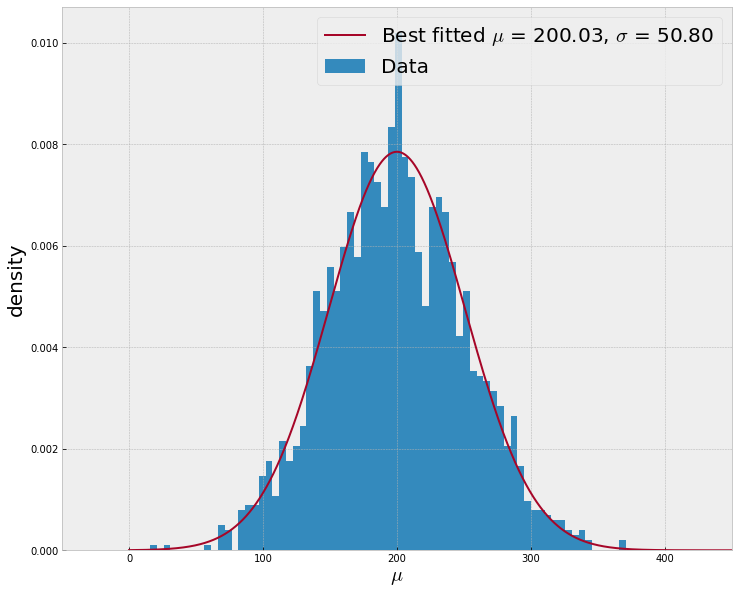

In [222]:
fig2, ax2 = plt.subplots(figsize=(12,10))
ax2.hist(data,bins = 70,density=True, label="Data")
x = np.arange(0, xmax, 0.1)


ax2.plot(x, gauss(x, mubest, sigma_best, truth.norm), lw =2 , label=r"Best fitted $\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(mubest[0], sigma_best[0]))

ax2.set_xlabel("$\mu$")
ax2.set_ylabel("density")
ax2.set_xlim(xmin, xmax)
ax2.legend(loc="upper right")
plt.show()